# Model Training

This notebook implements the training pipeline for a convolutional neural network to classify mushroom species. Using the dataset splits created in the previous notebook (`02_dataset_preparation.ipynb`), we train a ResNet-based model with transfer learning from ImageNet pre-trained weights.

The training process includes:

- **Data Loading**: Loading the training, validation, and test splits with appropriate data transformations
- **Model Architecture**: Using pre-trained ResNet models, here trained for mushroom species classification
- **Training Loop**: Implementing gradient accumulation, learning rate scheduling, and model checkpointing
- **Evaluation**: Model evaluation with accuracy, recall, and AUROC metrics
- **Model Selection**: Best model selection based on validation recall performance

## Key Training Configuration

- **Effective Batch Size**: 256 to align with ResNet optimization behavior
- **Epochs**: Early stopping based on validation performance  
- **Learning Rate**: Adaptive with ReduceLROnPlateau scheduler
- **Loss Function**: CrossEntropyLoss for binary classification
- **Optimizer**: Adam with weight decay for regularization

## Binary Classification Problem

- **Class 0**: Edible mushrooms (`Boletus edulis`, `Imleria badia`)
- **Class 1**: Inedible/bitter mushrooms (`Tylopilus felleus`)
- **Primary Metric**: Recall for positive class (class 1) - used for model selection
- **Monitoring Metrics**: AUROC and accuracy for comprehensive performance assessment
- **Proper Scaling**: All metrics reported as decimal values (0.0-1.0) following ML conventions

### Output Files

The training process generates:

- `checkpoints/ResNet18_best_model.pth`: Best model weights based on validation recall
- `checkpoints/ResNet18_epoch_X.pth`: Training checkpoints with intermediate results
- Training logs and performance metrics

## Load Dataset Splits

First, we load the dataset splits created in the previous notebook and set up the data loaders with appropriate transformations for training and evaluation.

In [5]:
import pandas as pd

from utils import get_transforms
from utils.image_dataset import ImageDataset

# These csv files are created in 02_dataset_preparation notebook
TRAINING_IDS_PATH = "data/training_split.csv"
VALIDATION_IDS_PATH = "data/validation_split.csv"

training_data = pd.read_csv(TRAINING_IDS_PATH)
validation_data = pd.read_csv(VALIDATION_IDS_PATH)

training_dataset = ImageDataset(
    training_data, transform=get_transforms(transform_type="training")
)
validation_dataset = ImageDataset(
    validation_data, transform=get_transforms(transform_type="testing")
)

print(f"Training dataset size: {len(training_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")

Training dataset size: 986
Validation dataset size: 210


## Configure Data Loaders

Data loaders are configured with specific batch size and gradient accumulation settings to optimize training performance. 

The effective batch size of 256 (batch size × accumulation steps) is chosen to match the optimization behavior of pre-trained ResNet models while accommodating memory constraints.

### Training Configuration

- **Batch Size**: Number of images per forward pass
- **Accumulation Steps**: Number of batches per gradient accumulation step
- **Workers**: Number of parallel processes

The gradient accumulation technique allows us to simulate larger batch sizes when GPU memory is limited, which is crucial for stable training of deep neural networks.

In [6]:
from torch.utils.data import DataLoader

# Configuration for DataLoader
ACCUMULATION_STEPS = 2 # Adjust based on memory constraints
WORKERS = 0  # Adjust based on your system's capabilities

if 256 % ACCUMULATION_STEPS != 0:
    raise ValueError(
        "Choose ACCUMULATION_STEPS such that ACCUMULATION_STEPS evenly divides BATCH_SIZE."
    )
BATCH_SIZE = 256 // ACCUMULATION_STEPS

train_loader = DataLoader(
    training_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS
)
valid_loader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(valid_loader)}")

Number of training batches: 8
Number of validation batches: 2


In [7]:
import torch
import torch.nn as nn

from utils import get_resnet_model

model = get_resnet_model("Resnet18")

# Adapt the final layer to the number of classes in dataset
number_classes = training_data["label_id"].nunique()
model.fc = nn.Linear(model.fc.in_features, number_classes)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model ready on {device}, configured for {number_classes} classes.")

Model ready on cpu, configured for 2 classes.


## Model Architecture Setup

We use a pre-trained ResNet18 model from torchvision with ImageNet weights as our base architecture. Transfer learning allows us to leverage features learned on a large-scale dataset and adapt them for mushroom classification.

### Model Adaptations

- **Feature Extraction**: Pre-trained convolutional layers serve as feature extractors
- **Classification Head**: Final fully connected layer is replaced to match the number of mushroom species
- **GPU Utilization**: Model is moved to GPU if available for faster training

The ResNet architecture is particularly well-suited for image classification tasks due to its residual connections that enable training of very deep networks while avoiding vanishing gradient problems.

## Training Configuration & Optimization

The training setup includes carefully chosen hyperparameters and optimization strategies to ensure stable and effective learning:

### Class Imbalance Considerations

The dataset has a slight class imbalance between edible and inedible mushrooms. However, this imbalance is mild and acceptable for several reasons:
- The imbalance is not severe (less than 2:1 ratio)
- We have sufficient samples in both classes for effective learning
- The ResNet architecture with transfer learning is quite robust to imbalances

### Optimization Components

- **Loss Function**: CrossEntropyLoss for binary classification
- **Optimizer**: Adam with learning rate 0.001 and weight decay 1e-4 for regularization
- **Scheduler**: ReduceLROnPlateau to adaptively reduce learning rate when validation loss plateaus
- **Gradient Accumulation**: Accumulation steps to achieve an effective batch size of 256

### Learning Rate Strategy

The ReduceLROnPlateau scheduler monitors validation loss and reduces the learning rate by a factor when no improvement is observed for a number of consecutive epochs. This adaptive approach helps the model converge to better local minima and prevents overfitting.

### Model Selection & Evaluation Metrics

The training process now uses **recall** as the primary metric for model selection, which is particularly important for this classification task where correctly identifying inedible mushrooms (positive class) is critical. The training function returns comprehensive metrics including:

- **Primary Selection Metric**: Recall - Used to select the best model checkpoint
- **Training Metrics**: Loss and accuracy per epoch
- **Validation Metrics**: Loss, accuracy, recall, and AUROC per epoch  
- **Best Model Tracking**: Best validation accuracy, AUROC, recall, and corresponding epoch
- **Model Checkpointing**: Best model saved based on validation recall performance

### AUROC for Performance Monitoring

While recall is used for model selection, AUROC is still computed and tracked to provide insight into the model's discrimination capability between edible and inedible mushrooms. This dual-metric approach ensures we select models with high recall while monitoring overall classification performance.

The training results are extracted and validated to ensure successful completion, with detailed performance reporting including the best epoch and corresponding metrics for both recall and AUROC.

In [4]:
from utils.model_training import train_model
import torch.optim as optim

# Training configuration
EPOCHS = 30

# Simple loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Use ReduceLROnPlateau for adaptive learning rate reduction
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.1,
    patience=5,
    min_lr=1e-6,
)

print(f"Starting training with {scheduler.__class__.__name__} scheduler")

# Training loop
training_results = train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=EPOCHS,
    accumulation_steps=ACCUMULATION_STEPS,
    checkpoint_dir="checkpoints",
    model_name="ResNet18",
)

# Extract results
if training_results is None:
    raise RuntimeError("Training failed - no results returned")

train_losses = training_results.get("train_losses", [])
train_accuracies = training_results.get("train_accuracies", [])
val_losses = training_results.get("val_losses", [])
val_accuracies = training_results.get("val_accuracies", [])
val_aurocs = training_results.get("val_aurocs", [])
val_recalls = training_results.get("val_recalls", [])
best_val_acc = training_results.get("best_val_acc", 0.0)
best_val_auroc = training_results.get("best_val_auroc", 0.0)
best_val_recall = training_results.get("best_val_recall", 0.0)
best_epoch = training_results.get("best_epoch", 0)

print(
    f"Training completed! Best model at epoch {best_epoch} - "
    f"Recall: {best_val_recall:.4f}, AUROC: {best_val_auroc:.4f}, Acc: {best_val_acc:.2f}%",
)

2025-07-18 11:23:25,847 - INFO - Starting training...


Starting training with ReduceLROnPlateau scheduler


2025-07-18 11:23:25,847 - INFO - Training for 30 epochs with accumulation steps 2
2025-07-18 11:23:25,848 - INFO - Best model selection based on: Recall
Validation: 100%|██████████| 2/2 [00:07<00:00,  3.71s/it, Loss=1.3180, Acc=76.67%]
2025-07-18 11:25:41,129 - INFO - New best Recall: 0.8444 (Acc: 76.67%, AUROC: 0.8086)
2025-07-18 11:25:41,323 - INFO - Checkpoint saved: checkpoints/ResNet18_epoch_01.pth
2025-07-18 11:25:41,324 - INFO - Epoch 1/30
2025-07-18 11:25:41,324 - INFO - ----------------------------------------
2025-07-18 11:25:41,324 - INFO - Train Loss: 0.8119, Train Acc: 61.97%
2025-07-18 11:25:41,324 - INFO - Val Loss: 1.3180, Val Acc: 76.67%, Val AUROC: 0.8086, Val Recall: 0.8444
2025-07-18 11:25:41,325 - INFO - Learning Rate: 0.001000
2025-07-18 11:25:41,325 - INFO - Epoch Time: 135.48s
Validation: 100%|██████████| 2/2 [00:07<00:00,  3.97s/it, Loss=5.3720, Acc=64.76%] 
2025-07-18 11:28:00,874 - INFO - Checkpoint saved: checkpoints/ResNet18_epoch_02.pth
2025-07-18 11:28:00

Training completed! Best model at epoch 11 - Recall: 0.9444, AUROC: 0.9226, Acc: 79.52%


## Training Results Visualization

The following plots show the training progress across epochs, including loss curves, recall performance, and AUROC scores. These visualizations help assess model convergence, overfitting, and overall training quality.

### Key Observations:

**Loss Curves**: Training and validation loss both decrease over time. Validation loss does not increase with increasing number of epochs, which indicates (considering learning rate **was** reduced) that the overfitting mitigation of reducing the learning rate at the plateau strategy works. However, total training loss is lower than validation loss which indicates the model is slightly overfitted.


**Recall Performance**: Increasing recall values show that the model becomes better at identifying positive cases (bitter boletes) and fewer dangerous mushrooms are misclassified as safe.


**AUROC Scores**: Increasing AUROC values indicate that the model's ability to distinguish between classes becomes better. Values closer to 1.0 indicate better discrimination capability.


**Best Epoch**: The best model was selected based on highest validation recall. Why this strategy has its caveats and draw-backs is visualized in the plots: while epoch 11 was selected as the best epoch, looking at the AUROC scores reveals that selection for the best recall alone does not necessarily yield the best model. Considering that the AUROC and accuracy values are higher in the checkpoint at epoch 15 – while the recall value is the same – one should rather select this model as the final result. One could also argue to choose checkpoints at a later epoch and trade slightly lower recall for higher accuracy.

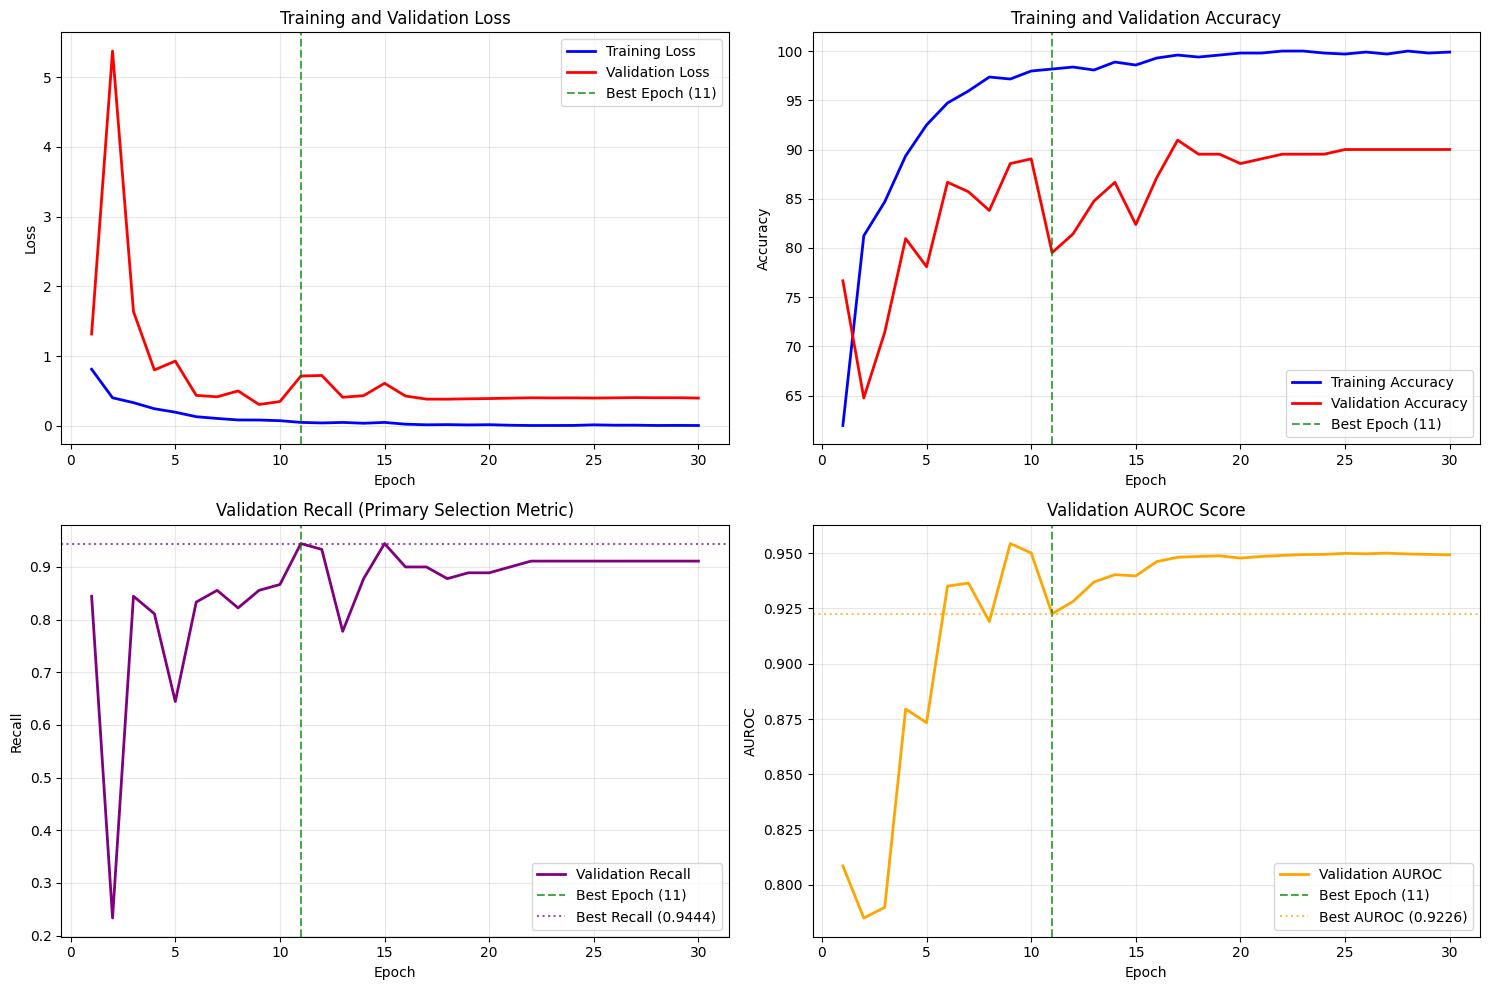

In [8]:
import matplotlib.pyplot as plt

# Create subplots for training metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training and Validation Loss
ax1.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Training and Validation Accuracy
ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
ax2.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Validation Recall
ax3.plot(range(1, len(val_recalls) + 1), val_recalls, 'purple', linewidth=2, label='Validation Recall')
ax3.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax3.axhline(y=best_val_recall, color='purple', linestyle=':', alpha=0.7, label=f'Best Recall ({best_val_recall:.4f})')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Recall')
ax3.set_title('Validation Recall (Primary Selection Metric)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Validation AUROC
ax4.plot(range(1, len(val_aurocs) + 1), val_aurocs, 'orange', linewidth=2, label='Validation AUROC')
ax4.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax4.axhline(y=best_val_auroc, color='orange', linestyle=':', alpha=0.7, label=f'Best AUROC ({best_val_auroc:.4f})')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('AUROC')
ax4.set_title('Validation AUROC Score')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()